# Домашнее задание. Сверточные нейронные сети (10 баллов)
В этом домашнем задании вы потренируетесь в построении полносвязных и сверточных нейронных сетей. Мы сравним качество нейросетей на датасете MNIST с рукописными цифрами. Наша цель --- построить нейронную сеть для решения задачи классификации цифр на 10 классов.

## Оценивание задания
Это задание будет проверяться в формате peer-review. Это означает, что вашу посылку на Stepik будут проверять 3 других учащихся, и медианное значение их оценок будет выставлено в качестве окончательного балла. Чтобы получить баллы, вам также нужно будет проверить трех других учеников. Это станет доступно после того, как вы сдадите задание сами.

## Оформление посылки
В качестве решения необходимо послать ноутбук в формате .ipynb. Пожалуйста, сделайте файл максимально читаемым. Если размер вашего файла превышает 5 Мб, приложите текстовый документ со ссылкой на файл в Google Drive (не забудьте обеспечить доступ на чтение). Пожалуйста, проследите, чтобы у файла было верное расширение: иначе у других участников могут возникнуть проблемы с прочтением.

## Рекомендации по решению
Подробные критерии проверки станут доступными во время проверки на Stepik. Пока мы предлагаем несколько правил, которые помогут вам набрать максимальное количество баллов.
* Сначала оформите ноутбук, а затем перезапустите среду выполнения и выполните ноутбук заново (Среда выполнения→перезапустить и выполнить всё). Так вы убедитесь, что итоговый код вашего ноутбука корректен.
* В ноутбуке есть два типа проверки: 2 `assert`'а и 4 ключевых вопроса. Корректное решение должно проходить все `assert`-ы. Также необходимо дать ответы на все вопросы из ноутбука.
* Чем более понятным и читаемым вы сделаете код, тем больше шансов, что проверяющий поставит вам за него высокий балл.

Желаем удачи!


In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import torchvision.transforms as tfs

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset   = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

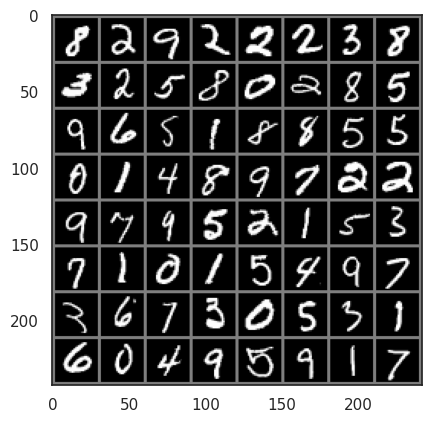

'    8     2     9     2     2     2     3     8'

In [55]:
from torchvision import datasets, transforms
import torchvision


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

' '.join('%5s' % labels[j].item() for j in range(8))

## Часть 1. Полносвязные нейронные сети (3 балла)
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть (1 балл)

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте функцию потерь для обучения (кросс-энтропия).


In [3]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10),
)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения (1 балл)

In [9]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          # x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all =  y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9032333333333333
Loader: valid. Accuracy: 0.9382
Epoch: 2
Loader: train. Accuracy: 0.9557666666666667
Loader: valid. Accuracy: 0.9549
Epoch: 3
Loader: train. Accuracy: 0.9672333333333333
Loader: valid. Accuracy: 0.97
Epoch: 4
Loader: train. Accuracy: 0.9734666666666667
Loader: valid. Accuracy: 0.9653
Epoch: 5
Loader: train. Accuracy: 0.9784
Loader: valid. Accuracy: 0.9721
Epoch: 6
Loader: train. Accuracy: 0.9806166666666667
Loader: valid. Accuracy: 0.9766
Epoch: 7
Loader: train. Accuracy: 0.9830166666666666
Loader: valid. Accuracy: 0.9775
Epoch: 8
Loader: train. Accuracy: 0.9837833333333333
Loader: valid. Accuracy: 0.97
Epoch: 9
Loader: train. Accuracy: 0.9858333333333333
Loader: valid. Accuracy: 0.9707
Epoch: 10
Loader: train. Accuracy: 0.9873833333333333
Loader: valid. Accuracy: 0.976


In [10]:
assert accuracy["valid"][-1] > 0.97, 'Модель недостаточно хорошая. Нужно искать ошибку!'

### Задание. Протестируйте разные функции активации (1 балл)
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

Вам необходимо попробовать следующие функции активации:
* тождественная функция активации $f(x) = x$ (класс Identical реализован за вас ниже)
* сигмоида;
* ReLU;
* Leaky ReLU;
* Tanh (гиперболический тангенс).


In [11]:
elu_accuracy = accuracy["valid"]

In [12]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    instance_activation = activation()
    return instance_activation.forward(torch.tensor(elu_accuracy))

In [13]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Sigmoid(nn.Module):
    def forward(self, x):
        return torch.sigmoid(x)

class ReLU(nn.Module):
    def forward(self, x):
        return torch.relu(x)

class LeakyReLU(nn.Module):
    def forward(self, x):
        leaky_relu = torch.nn.LeakyReLU(0.1)  # 0.1 - параметр наклона
        return leaky_relu(x)

class Tanh(nn.Module):
    def forward(self, x):
        return torch.tanh(x)

In [14]:
plain_accuracy = test_activation_function(Identical)
sigmoid_accuracy = test_activation_function(Sigmoid)
relu_accuracy = test_activation_function(ReLU)
leaky_relu_accuracy = test_activation_function(LeakyReLU)
tanh_accuracy = test_activation_function(Tanh)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

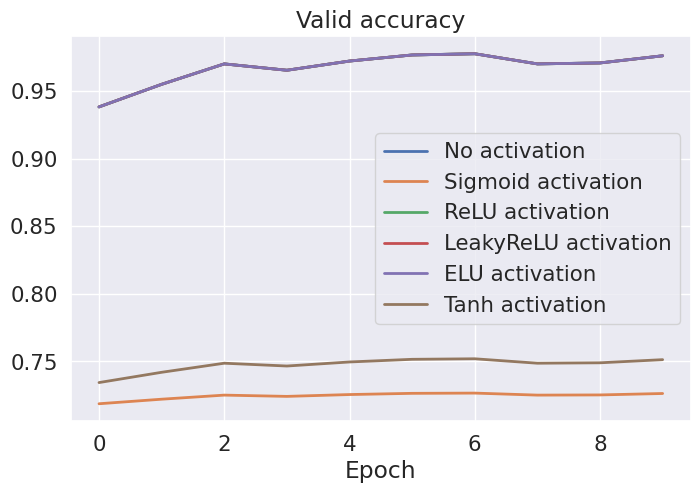

In [15]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), sigmoid_accuracy, label="Sigmoid activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

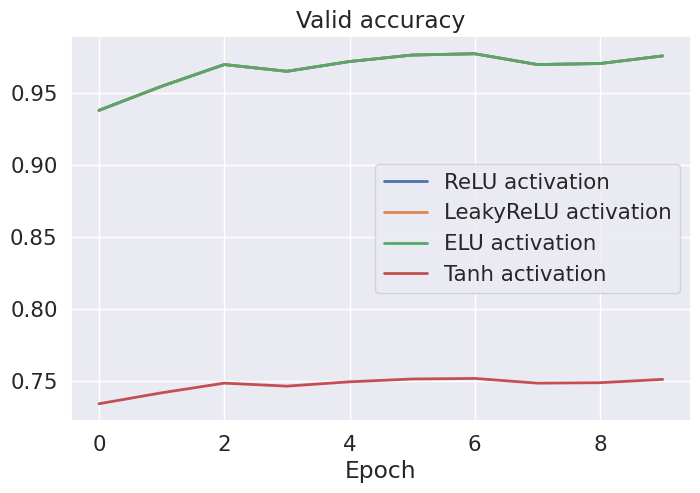

In [16]:
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 1.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2 Сверточные нейронные сети (7 баллов)

### Ядра (1 балл)
Сначала немного поработам с самим понятием ядра свёртки.

In [17]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-05-29 12:55:00--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   209KB/s    in 0.2s    

2024-05-29 12:55:01 (209 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



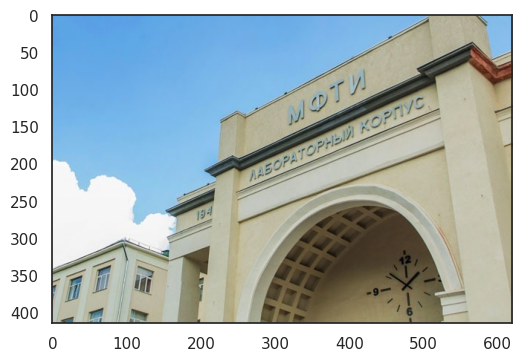

In [18]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 4))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [19]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

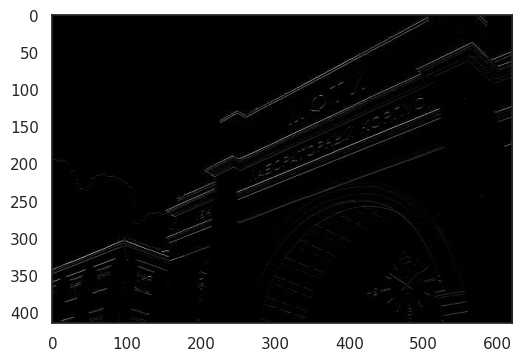

In [20]:
plt.figure(figsize=(6, 4))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

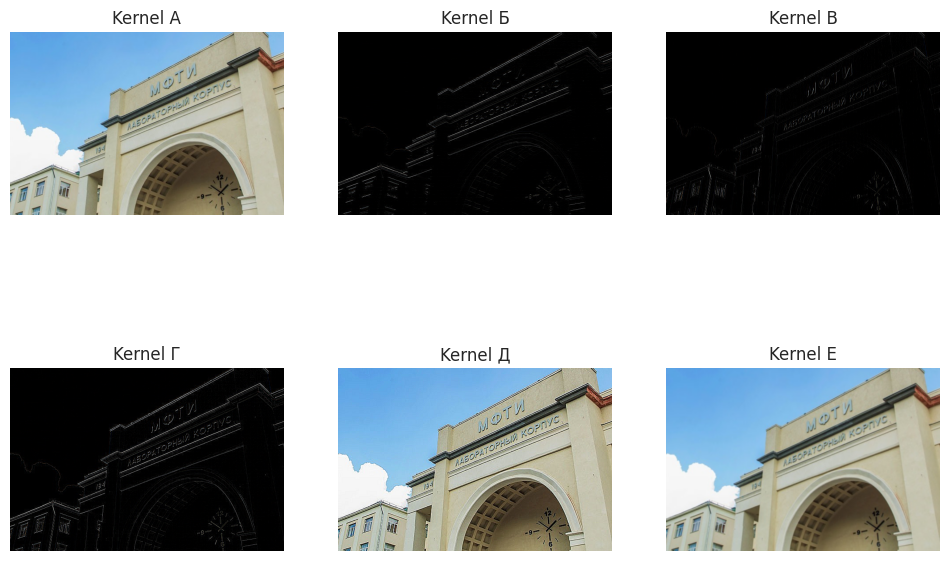

In [21]:
# image = cv2.imread('sample_photo.jpg', cv2.IMREAD_GRAYSCALE)

image = RGB_img

kernels = {
    'А': np.array([[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, 0]]),
    'Б': np.array([[0, 1, 0],
                   [0, -2, 0],
                   [0, 1, 0]]),
    'В': np.array([[0, 0, 0],
                   [1, -2, 1],
                   [0, 0, 0]]),
    'Г': np.array([[0, 1, 0],
                  [1, -4, 1],
                  [0, 1, 0]]),
    'Д': np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]]),
    'Е': np.array([[0.0625, 0.125, 0.0625],
                   [0.125, 0.25, 0.125],
                   [0.0625, 0.125, 0.0625]])
}

convolved_images = {}
for name, kernel in kernels.items():
    convolved_image = cv2.filter2D(image, -1, kernel)
    convolved_images[name] = convolved_image

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for (name, image), ax in zip(convolved_images.items(), axes.flat):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Kernel {name}')
    ax.axis('off')

plt.show()

**Вопрос 2.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:** Е Д А В Б Г

### Задание. Реализуйте LeNet (3 балла)

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [22]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1) # Equivalent to nn.Flatten()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN (3 балла)
Используйте код обучения, который вы написали для полносвязной нейронной сети. Обратите внимание, что сверточная нейронная сеть будет обучаться дольше. Нейронную сеть необходимо обучить до стабилизации графика функции потерь на валидационной выборке! Для этого может потребоваться большое количество эпох.

С какого-то момента качество на валидационной выборке начнет снова падать. В этот момент обучение можно прекращать.

Обратите внимание, что если модель не успела сойтись и вам нужно большее количество эпох, модель можно не переобучать с нуля, а запустить с уже частично обученными весами. Подумайте, как это сделать в коде.


Лучше запустить два эксперимента: на первом эксперименте оценить необходимое количество эпох, а на втором --- запустить обучение на таком количестве эпох и посчитать качество обученной модели на последней эпохе. Если бы в нашем распоряжении была тестовая выборка, можно было бы взять лучшую модель на валидации и вычислить ее качество на тесте.

In [24]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          # x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9108833333333334
Loader: valid. Accuracy: 0.9745
Epoch: 2
Loader: train. Accuracy: 0.9752
Loader: valid. Accuracy: 0.982
Epoch: 3
Loader: train. Accuracy: 0.9825
Loader: valid. Accuracy: 0.9855
Epoch: 4
Loader: train. Accuracy: 0.9860333333333333
Loader: valid. Accuracy: 0.987
Epoch: 5
Loader: train. Accuracy: 0.9889166666666667
Loader: valid. Accuracy: 0.9878
Epoch: 6
Loader: train. Accuracy: 0.9908666666666667
Loader: valid. Accuracy: 0.9866
Epoch: 7
Loader: train. Accuracy: 0.9912833333333333
Loader: valid. Accuracy: 0.9871
Epoch: 8
Loader: train. Accuracy: 0.9927333333333334
Loader: valid. Accuracy: 0.9879
Epoch: 9
Loader: train. Accuracy: 0.9938166666666667
Loader: valid. Accuracy: 0.9905
Epoch: 10
Loader: train. Accuracy: 0.9948166666666667
Loader: valid. Accuracy: 0.9893


In [59]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9982666666666666
Loader: valid. Accuracy: 0.9888
Epoch: 2
Loader: train. Accuracy: 0.99845
Loader: valid. Accuracy: 0.9871
Epoch: 3
Loader: train. Accuracy: 0.9984666666666666
Loader: valid. Accuracy: 0.9871
Epoch: 4
Loader: train. Accuracy: 0.99845
Loader: valid. Accuracy: 0.9882
Epoch: 5
Loader: train. Accuracy: 0.9986166666666667
Loader: valid. Accuracy: 0.9901


Сравним с предыдущем пунктом

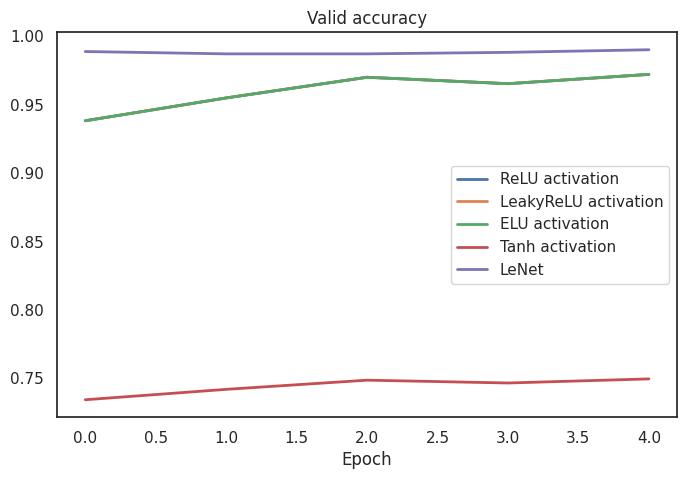

In [63]:
# Epoches 5

lenet_accuracy = accuracy["valid"]

plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy[:5], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy[:5], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy[:5], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy[:5], label="Tanh activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy[:5], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 3**. Стабилизировалось ли качество вашей модели? Какая модель из всех обученных показала лучший результат?

**Ответ:** Качество модели стабилизировалось. LeNet

**Вопрос 4**. Посчитайте accuracy после обучения с точностью до четырех знаков после запятой. Укажите качество с **последней** эпохи на валидационной выборке. **Обратите внимание, после перезапуска ноутбука перед отправкой на Stepik это число может измениться, так как есть небольшая случайная вариативность. Введите ответ, который дает итоговая версия вашего ноутбука.**
**Ответ:** 0.9901

In [61]:
best_accuracy = lenet_accuracy[-1]
assert best_accuracy > 0.987, 'Модель недостаточно хорошая. Нужно лучше!'